In [1]:
'''
Hi,All

Here is the final lab with details given in lab5, in which the template model is Quadratic chirp, and SNR=10，a1 = 10, a2=3, a3 = 3 are the true parameters used in lab5 for illustration. 

In the final lab,  the PSD and the true values of SNR,a1,a2,a3 are unknown for you. We provide TrainningData for you to estimate the PSD numerically via pwelch,  then you would take the estimated PSD to matched filtering, searching the Quadratic chirp signal injected in analysisData by running PSO.  The bestfit SNR，a1, a2, a3 returned by PSO should be considsent with our injected values  if you handle it in a correct way.
'''

'\nHi,All\n\nHere is the final lab with details given in lab5, in which the template model is Quadratic chirp, and SNR=10，a1 = 10, a2=3, a3 = 3 are the true parameters used in lab5 for illustration. \n\nIn the final lab,  the PSD and the true values of SNR,a1,a2,a3 are unknown for you. We provide TrainningData for you to estimate the PSD numerically via pwelch,  then you would take the estimated PSD to matched filtering, searching the Quadratic chirp signal injected in analysisData by running PSO.  The bestfit SNR，a1, a2, a3 returned by PSO should be considsent with our injected values  if you handle it in a correct way.\n'

In [2]:
from scipy.io import loadmat
import numpy as np

### Load the TrainingData.mat file
data1 = loadmat('.\data\TrainingData.mat')
# Print the keys in the loaded data
print('Keys in the loaded data from TrainingData.mat:', data1.keys())

# sample frequency
fs = data1['sampFreq'].ravel()[0]
print('sample frequency:',fs)

# training data
trainData = data1['trainData'].ravel()
print('train data shape:',trainData.shape)  
print('train data:',trainData)       
print( )

### Load the analysisData.mat file
data2 = loadmat(r'.\data\analysisData.mat')
# Print the keys in the loaded data
print('Keys in the loaded data from analysisData.mat:', data2.keys())

# analysis data
analysisData = data2['dataVec'].ravel()
nsamples=len(analysisData)
print('analysis data shape:',analysisData.shape)  
print('analysis data:',analysisData) 

# time vector
time_vec = np.arange(len(analysisData)) / fs

Keys in the loaded data from TrainingData.mat: dict_keys(['__header__', '__version__', '__globals__', 'sampFreq', 'trainData'])
sample frequency: 1024
train data shape: (20081,)
train data: [ 2.10880613e-21  1.67217122e-21  1.10893113e-22 ... -1.00058413e-22
  4.03440805e-22 -1.47846821e-21]

Keys in the loaded data from analysisData.mat: dict_keys(['__header__', '__version__', '__globals__', 'dataVec', 'sampFreq'])
analysis data shape: (2048,)
analysis data: [-4.08021771e-22  3.85023527e-22 -6.86593915e-22 ... -1.63285175e-21
  1.28946321e-21  1.15863140e-22]


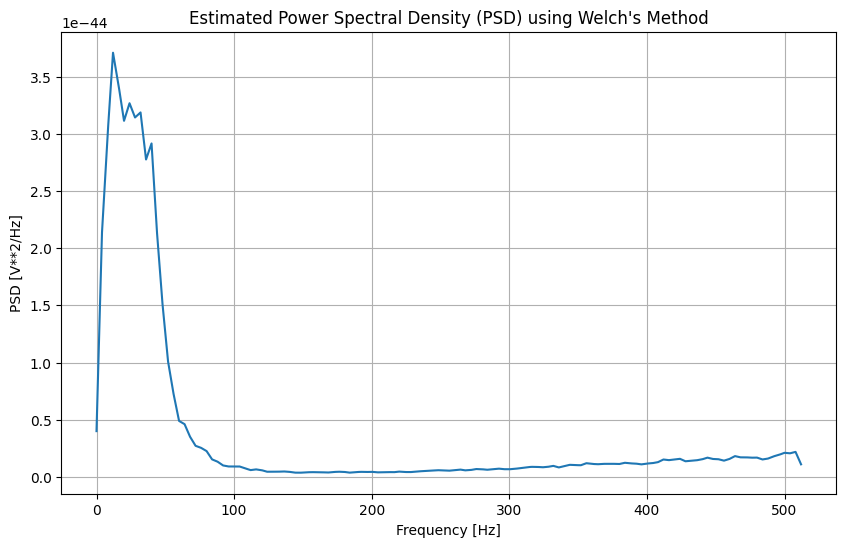

In [3]:
from scipy import signal
import matplotlib.pyplot as plt

### Estimate the PSD using Welch's method
f, psd_vec = signal.welch(trainData, fs, nperseg=256) # one-sided PSD
psd_vec = psd_vec /2 # Scale the PSD to convert it from one-sided to two-sided.

#convert  frequencies into the required DFT frequencies using linear interpolation
from scipy.interpolate import interp1d
data_len = nsamples / fs
k_nyq = nsamples // 2 +1
pos_freq = np.arange(k_nyq) / data_len
interp_func = interp1d(f , psd_vec, kind='linear', bounds_error=False, fill_value="extrapolate")
psd_interp = interp_func(pos_freq)
f = pos_freq
psd_vec = psd_interp

# Plot the estimated PSD
plt.figure(figsize=(10, 6))
plt.plot(f, psd_vec)
plt.title('Estimated Power Spectral Density (PSD) using Welch\'s Method')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid()
plt.show()

Progress: 100.0%
result corresponding to min cost:
Epoch： 1874
cost(-GLRT)： -63.42615644865632

Estimated parameters of the quadratic chirp signal:
position[a1,a2,a3]： [49.25352728 31.23163198  9.53159801]
Estimated SNR: 7.964054020952917


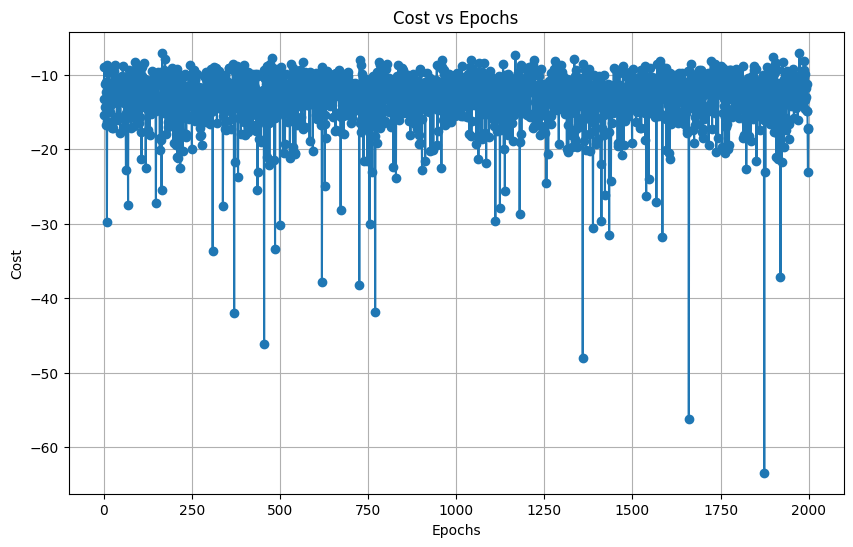

In [4]:
from function import glrtqcsig
import sys
import time
from pyswarms.single import GlobalBestPSO
from functools import partial
import matplotlib.pyplot as plt

# Define the objective function for PSO
def object_func(qcCoefs,time_vec,data_vec, fs,psd_vec):
    ## qcCoefs: shape (n_particles, 3)
    output= np.zeros(qcCoefs.shape[0])
    for i in range(qcCoefs.shape[0]):
        output[i]=-glrtqcsig(time_vec,data_vec, fs,psd_vec,qcCoefs[i])
    return output

# PSO options
# options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
options = {'c1': 0.2, 'c2': 0.1, 'w': 0.99} # c1, c2, w are the cognitive, social and inertia weights respectively
n_runs = 2000 # Number of runs for PSO
min_bounds = [0,0,0 ]  # Lower bounds for a1, a2,a3 of the quadratic chirp signal
max_bounds = [100, 100, 100]  # # Upper bounds for a1, a2,a3 of the quadratic chirp signal

# Run PSO for n_runs iterations
bounds = (min_bounds, max_bounds)
results = []
for i in range(n_runs):


    # Print progress
    time.sleep(0.1)
    progress = (i + 1) / n_runs * 100
    sys.stdout.write(f"\rProgress: {progress:.1f}%")
    sys.stdout.flush()
    # Initialize PSO optimizer
    optimizer = GlobalBestPSO(
        n_particles=100, # Number of particles in the swarm
        dimensions=3, # Number of dimensions (3 for a1, a2, a3)
        options=options, # PSO options
        bounds=bounds, # Bounds for the parameters
        ftol=1e-6,  # Tolerance for convergence
        ftol_iter=5 # Number of iterations for convergence check
    )

    # Optimize the objective function
    func = partial(object_func, time_vec=time_vec, data_vec=analysisData, fs=fs, psd_vec=psd_vec) 
    cost, pos = optimizer.optimize(func, iters=100,verbose=False) #cost is the minimum value of the objective function, pos is the best position found by PSO

    results.append([i,cost, pos])

# Print the best record
best_record = min(results, key=lambda x: x[1]) 
print()
print('result corresponding to min cost:')
print("Epoch：", best_record[0])
print("cost(-GLRT)：", best_record[1])
print()
print('Estimated parameters of the quadratic chirp signal:')
print("position[a1,a2,a3]：", best_record[2])
print("Estimated SNR:",np.sqrt(-best_record[1]))

#plot the cost vs epoch
epochs = [record[0] for record in results]
costs = [record[1] for record in results]
plt.figure(figsize=(10, 6))
plt.plot(epochs, costs, marker='o', linestyle='-')
plt.title('Cost vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.show()
